# Data Science in Economics and Business - Class Project
In this class project, you are supposed to work with GDP data taken from the International Monetary Fund.

**IMPORTANT:** <br>
Please enter the matriculation number of all group members here:
1. XXXXXX
2. YYYYYY
3. ZZZZZZ

API key: S4fKTjESiijBFS7URg8z

In this class project, you will use the different techniques taught in the course: data handling, data visualization, and machine learning.

First load the necessary packages. <br>
If you want to use additional libraries you can add them to the following cell:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import world_bank_data as wb
import wbgapi as wba
import datetime
sns.set()
import folium
from folium.plugins import MarkerCluster
import plotly.express as px
import logging

pd.set_option('display.max_rows', None)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [2]:
#Little test with wbgapi, to build directly a dataframe
# https://nbviewer.org/github/tgherzog/wbgapi/blob/master/examples/wbgapi-cookbook.ipynb
wba.data.DataFrame(['SP.POP.TOTL', 'NY.GDP.PCAP.CD'],
                  time=range(2010,2015), skipBlanks=True, columns='series').head()

NY.GDP.PCAP.CD  SP.POP.TOTL
economy time                               
ABW     YR2010    24452.928363     100341.0
        YR2011    26044.435933     101288.0
        YR2012    25609.955724     102112.0
        YR2013    26515.678080     102880.0
        YR2014    26942.307976     103594.0

In [3]:
#Get countries from World Bank API and drop unnecessary data
countries = wb.get_countries()
countries = countries[countries['incomeLevel'] != 'Aggregates'].rename(columns={'name': 'countryName'})
countries.drop(['iso2Code', 'adminregion', 'capitalCity', 'lendingType', 'longitude', 'latitude'], axis=1, inplace=True)
countries.reset_index(level=0, inplace=True)
countries.head

<bound method NDFrame.head of       id                     countryName                      region  \
0    ABW                           Aruba  Latin America & Caribbean    
1    AFG                     Afghanistan                  South Asia   
2    AGO                          Angola         Sub-Saharan Africa    
3    ALB                         Albania       Europe & Central Asia   
4    AND                         Andorra       Europe & Central Asia   
5    ARE            United Arab Emirates  Middle East & North Africa   
6    ARG                       Argentina  Latin America & Caribbean    
7    ARM                         Armenia       Europe & Central Asia   
8    ASM                  American Samoa         East Asia & Pacific   
9    ATG             Antigua and Barbuda  Latin America & Caribbean    
10   AUS                       Australia         East Asia & Pacific   
11   AUT                         Austria       Europe & Central Asia   
12   AZE                      Azer

In [4]:
current_year = datetime.datetime.now().year

In [5]:
LABOR_FORCE_PARTICIPATION = wb.get_series('SL.TLF.CACT.NE.ZS', id_or_value="id", simplify_index=True, date='1994:'+str(current_year))
LABOR_FORCE_PARTICIPATION

Country  Year
AFE      1994          NaN
         1995          NaN
         1996          NaN
         1997          NaN
         1998          NaN
         1999          NaN
         2000          NaN
         2001          NaN
         2002          NaN
         2003          NaN
         2004          NaN
         2005          NaN
         2006          NaN
         2007          NaN
         2008          NaN
         2009          NaN
         2010          NaN
         2011          NaN
         2012          NaN
         2013          NaN
         2014          NaN
         2015          NaN
         2016          NaN
         2017          NaN
         2018          NaN
         2019          NaN
         2020          NaN
         2021          NaN
         2022          NaN
AFW      1994          NaN
         1995          NaN
         1996          NaN
         1997          NaN
         1998          NaN
         1999          NaN
         2000          NaN
         2001 

In [6]:
data_series_dict = {
    'labor_force_participation': 'SL.TLF.CACT.NE.ZS',
    'unemployment_total': 'SL.UEM.TOTL.ZS',
    'rural_population': 'SP.RUR.TOTL',
    'rural_population_percent': 'SP.RUR.TOTL.ZS',
    'ratio_female_male_labor_force': 'SL.TLF.CACT.FM.ZS',
    'gini_index': 'SI.POV.GINI',
    'poverty_headcount_ratio': 'SI.POV.DDAY',
    'ghg_emissions': 'EN.ATM.GHGT.ZG',
    'urban_population_growth': 'SP.URB.GROW',
    'under_5_mortality': 'SH.DYN.MORT',
    'net_official_development_aid': 'DT.ODA.ALLD.CD',
    'net_migration': 'SM.POP.NETM',
    'access_to_electricity': 'EG.ELC.ACCS.ZS',
    'energy_use': 'EG.USE.PCAP.KG.OE',
    'population_growth': 'SP.POP.GROW',
    'adjusted_net_income': 'NY.ADJ.NNTY.CD',
    'school_enrollment': 'SE.PRE.ENRR',
    'government_debt': 'GC.DOD.TOTL.GD.ZS',
    'maternal_death_risk': 'SH.MMR.RISK.ZS',
    'inflation': 'FP.CPI.TOTL.ZG',
    'age_dependency_ratio': 'SP.POP.DPND',
    'birth_rate': 'SP.DYN.CBRT.IN',
    'death_rate': 'SP.DYN.CDRT.IN',
    'hospital_beds': 'SH.MED.BEDS.ZS',
    'logistics_performance_index': 'LP.LPI.OVRL.XQ',
    'tariff_rate': 'TM.TAX.MRCH.SM.AR.ZS',
    'total_labor_force': 'SL.TLF.TOTL.IN',
    'armed_forces_personnel': 'MS.MIL.TOTL.P1',
    'trade_percent_gdp': 'NE.TRD.GNFS.ZS',
    'female_suicide_rate': 'SH.STA.SUIC.FE.P5',
    'secure_internet_servers': 'IT.NET.SECR',
    'patent_applications': 'IP.PAT.RESD'
}

df = pd.DataFrame()

for var_name, series_name in data_series_dict.items():
    #Get series with the dict
    data_series = wb.get_series(series_name, date='1994:'+str(current_year), id_or_value='id')

    # Reset index, drop 'Series' column, and rename the series column
    data_series_df = data_series.reset_index().drop(columns=['Series'])
    data_series_df.rename(columns={series_name: var_name}, inplace=True)

    # If result DataFrame is empty, copy the current data
    if df.empty:
        df = data_series_df.copy()
    else:
        # Otherwise merge current data with existing DataFrame
        df = pd.merge(df, data_series_df, on=['Country', 'Year'], how='outer')
df.head()

Country  Year  labor_force_participation  unemployment_total  \
0     AFE  1994                        NaN            7.160694   
1     AFE  1995                        NaN            7.063796   
2     AFE  1996                        NaN            7.055998   
3     AFE  1997                        NaN            7.090541   
4     AFE  1998                        NaN            7.060096   

   rural_population  rural_population_percent  ratio_female_male_labor_force  \
0       251602062.0                 73.051291                      83.236716   
1       256845485.0                 72.664712                      83.825490   
2       262711347.0                 72.375103                      84.102386   
3       268424729.0                 72.088928                      84.339786   
4       274058918.0                 71.796625                      84.605244   

   gini_index  poverty_headcount_ratio  ghg_emissions  ...  death_rate  \
0         NaN                      NaN            NaN  ...   16.280766   
1         NaN                      NaN            NaN  ...   14.820095   
2         NaN                      NaN            NaN  ...   14.832115   
3         NaN                      NaN            NaN  ...   14.634215   
4         NaN                      NaN            NaN  ...   15.147919   

   hospital_beds  logistics_performance_index  tariff_rate  total_labor_force  \
0            NaN                          NaN          NaN        134181053.0   
1            NaN                          NaN          NaN        138169361.0   
2            NaN                          NaN          NaN        141973175.0   
3            NaN                          NaN          NaN        145688984.0   
4            NaN                          NaN          NaN        149656118.0   

   armed_forces_personnel  trade_percent_gdp  female_suicide_rate  \
0                794000.0          47.256914                  NaN   
1               1342300.0          49.319926                  NaN   
2               1296000.0          48.747941                  NaN   
3               1248390.0          46.427172                  NaN   
4               1284350.0          47.200993                  NaN   

   secure_internet_servers  patent_applications  
0                      NaN                  NaN  
1                      NaN                  NaN  
2                      NaN                  NaN  
3                      NaN                  NaN  
4                      NaN                  NaN  

[5 rows x 34 columns]

In [7]:
# Merge country information into the df
df = pd.merge(df, countries, left_on='Country', right_on='id')
df.drop(['id'], axis=1, inplace=True)
df.set_index(['Country', 'Year'], inplace=True)
print(df)

              labor_force_participation  unemployment_total  rural_population  \
Country Year                                                                    
AFG     1994                        NaN               8.111        12127356.0   
        1995                        NaN               8.260        12868486.0   
        1996                        NaN               8.165        13392069.0   
        1997                        NaN               8.089        13909967.0   
        1998                        NaN               8.082        14444061.0   
        1999                        NaN               8.070        15027717.0   
        2000                        NaN               8.054        15228282.0   
        2001                        NaN               8.040        15323859.0   
        2002                        NaN               8.186        16325389.0   
        2003                        NaN               8.122        17583264.0   
        2004                

In [8]:
list(df)

['labor_force_participation',
 'unemployment_total',
 'rural_population',
 'rural_population_percent',
 'ratio_female_male_labor_force',
 'gini_index',
 'poverty_headcount_ratio',
 'ghg_emissions',
 'urban_population_growth',
 'under_5_mortality',
 'net_official_development_aid',
 'net_migration',
 'access_to_electricity',
 'energy_use',
 'population_growth',
 'adjusted_net_income',
 'school_enrollment',
 'government_debt',
 'maternal_death_risk',
 'inflation',
 'age_dependency_ratio',
 'birth_rate',
 'death_rate',
 'hospital_beds',
 'logistics_performance_index',
 'tariff_rate',
 'total_labor_force',
 'armed_forces_personnel',
 'trade_percent_gdp',
 'female_suicide_rate',
 'secure_internet_servers',
 'patent_applications',
 'countryName',
 'region',
 'incomeLevel']

In [9]:
df['labor_force_participation'] = df['labor_force_participation'].interpolate(limit_direction='both')
df['secure_internet_servers'] = df['secure_internet_servers'].fillna(0)

df.loc['USA'].head(20)

labor_force_participation  unemployment_total  rural_population  \
Year                                                                    
1994                      66.66                6.12        60847887.0   
1995                      66.72                5.65        60559606.0   
1996                      66.87                5.45        60247274.0   
1997                      67.20                5.00        59962727.0   
1998                      67.09                4.51        59647910.0   
1999                      67.08                4.22        59318323.0   
2000                      67.07                3.99        59093274.0   
2001                      66.82                4.73        59176653.0   
2002                      66.58                5.78        59224903.0   
2003                      66.24                5.99        59231337.0   
2004                      65.99                5.53        59272576.0   
2005                      66.05                5.08        59316092.0   
2006                      66.18                4.62        59380586.0   
2007                      66.04                4.62        59435929.0   
2008                      65.99                5.78        59486862.0   
2009                      65.37                9.25        59495270.0   
2010                      64.71                9.63        59477423.0   
2011                      64.11                8.95        59375348.0   
2012                      63.70                8.07        59263241.0   
2013                      63.25                7.37        59106371.0   

      rural_population_percent  ratio_female_male_labor_force  gini_index  \
Year                                                                        
1994                    23.125                      78.001061        40.0   
1995                    22.743                      78.402472        39.9   
1996                    22.364                      78.839767        40.3   
1997                    21.992                      79.591420        40.5   
1998                    21.623                      79.778650        40.0   
1999                    21.258                      80.109419        40.0   
2000                    20.943                      80.210690        40.1   
2001                    20.766                      80.463190        40.6   
2002                    20.591                      80.651433        40.4   
2003                    20.417                      81.149000        40.8   
2004                    20.243                      80.952779        40.3   
2005                    20.072                      81.102362        41.0   
2006                    19.901                      81.123727        41.4   
2007                    19.731                      81.338008        40.8   
2008                    19.562                      81.872443        40.8   
2009                    19.394                      82.651133        40.6   
2010                    19.228                      82.703766        40.0   
2011                    19.056                      82.504953        40.9   
2012                    18.881                      82.175668        40.9   
2013                    18.701                      81.931564        40.7   

      poverty_headcount_ratio  ghg_emissions  urban_population_growth  \
Year                                                                    
1994                      0.5       3.893124                 1.730982   
1995                      0.5       3.735326                 1.686467   
1996                      0.7       7.197081                 1.652783   
1997                      0.7       9.587874                 1.681975   
1998                      0.7       9.988808                 1.637628   
1999                      0.7      10.952315                 1.612957   
2000                      0.7      13.575906                 1.512011   
2001                      0.7      11.165770   

In [10]:
missing_values = df.isnull().sum()
missing_values.sort_values(ascending=False, inplace=True)
missing_values

logistics_performance_index      5222
government_debt                  4669
gini_index                       4578
poverty_headcount_ratio          4568
hospital_beds                    3753
patent_applications              3539
energy_use                       3211
ghg_emissions                    2902
tariff_rate                      2755
female_suicide_rate              2633
school_enrollment                2555
maternal_death_risk              2408
armed_forces_personnel           1983
net_official_development_aid     1956
adjusted_net_income              1666
inflation                        1253
trade_percent_gdp                1179
unemployment_total                876
ratio_female_male_labor_force     876
total_labor_force                 876
under_5_mortality                 805
access_to_electricity             653
death_rate                        321
birth_rate                        310
net_migration                     217
urban_population_growth            58
rural_popula

In [11]:
missing_values_per_country = df.isnull().sum(axis=1)
missing_values_per_country.sort_values(ascending=False, inplace=True)
print(missing_values_per_country)


Country  Year
MAF      2022    28
XKX      2022    26
ASM      2022    25
CUW      2022    25
CYM      2022    25
MCO      2022    25
IMN      2022    25
VGB      2022    25
KIR      2022    25
GRL      2022    25
ABW      2022    25
AND      2022    25
SXM      2022    25
LIE      2022    25
MHL      2022    25
GIB      2022    25
TCA      2022    25
FRO      2022    25
SMR      2022    25
DMA      2022    25
TUV      2022    25
MNP      2022    25
MAF      2015    24
         2006    24
         1997    24
         1998    24
SYC      2022    24
MAF      1995    24
BMU      2022    24
MAF      1999    24
         2000    24
         2001    24
         2002    24
         2003    24
         2004    24
         2005    24
GRD      2022    24
MAF      2016    24
         2007    24
         2008    24
         2010    24
KNA      2022    24
MAF      1994    24
         2011    24
         2021    24
         2020    24
         2019    24
         2012    24
         2013    24
      

# Problem 1 - Data Handling
The basis of your work will be the following GDP dataset:

In [12]:
gdp = pd.read_csv("GDP_IMF.csv", sep=";")
gdp.sample(20)

Country  year       GDP
6561           Trinidad and Tobago  2020    21.059
424                Africa (Region)  1993   605.136
4316  Sub-Saharan Africa (Region)   2010  1446.242
127                        Nigeria  1992    52.275
1970                   Saint Lucia  2000     0.932
3196                        Angola  2006    52.381
2306                      Bulgaria  2002    16.403
2857                         Nauru  2004     0.031
1063                       Senegal  1996       6.3
2392                        Mexico  2002    772.11
1602                     Argentina  1999   316.998
4746                 United States  2012  16253.95
4957         Sao Tome und Principe  2013     0.303
824                    Puerto Rico  1995    42.647
4866                     Indonesia  2013   916.646
8358                  Saudi Arabia  2028  1256.783
895                 Southeast Asia  1995   723.172
7437                         Qatar  2024    225.67
3610                     Venezuela  2007   232.857
3037                      Honduras  2005     9.757

#### a)
As you can see, there are many missing values in the data. <br>
Before you can continue, you need to handle them. Proceed as follows:
- Delete those countries with no data at all (if any)
- Either delete the missing years for each country or use the years close by to approximate the missing value <br> *Example: Year 2004 is missing, but 2003 and 2005 are available; use the mean of GDP in 2003 and 2005 to replace missing year 2004.*

Replace name of the Congos and remove additional information

In [13]:
gdp.groupby('Country').filter(lambda x: all(x['GDP']=='no data'))

Empty DataFrame
Columns: [Country, year, GDP]
Index: []

All countrys have atleast some years with GDP data

In [14]:
gdp.groupby('year').filter(lambda x: all(x['GDP']=='no data'))

Empty DataFrame
Columns: [Country, year, GDP]
Index: []

All years have atleast some countrys with GDP data

In [15]:
gdp.sort_values(by=['Country', 'year'], inplace=True)

In [16]:
gdp[gdp['Country']=='Sao Tome und Principe'].head(40)

Country  year    GDP
169   Sao Tome und Principe  1992  0.096
397   Sao Tome und Principe  1993  0.127
625   Sao Tome und Principe  1994  0.132
853   Sao Tome und Principe  1995  0.104
1081  Sao Tome und Principe  1996  0.136
1309  Sao Tome und Principe  1997  0.093
1537  Sao Tome und Principe  1998  0.073
1765  Sao Tome und Principe  1999  0.078
1993  Sao Tome und Principe  2000  0.077
2221  Sao Tome und Principe  2001  0.072
2449  Sao Tome und Principe  2002   0.08
2677  Sao Tome und Principe  2003  0.096
2905  Sao Tome und Principe  2004  0.104
3133  Sao Tome und Principe  2005  0.125
3361  Sao Tome und Principe  2006  0.133
3589  Sao Tome und Principe  2007  0.145
3817  Sao Tome und Principe  2008  0.188
4045  Sao Tome und Principe  2009  0.188
4273  Sao Tome und Principe  2010  0.197
4501  Sao Tome und Principe  2011  0.233
4729  Sao Tome und Principe  2012  0.253
4957  Sao Tome und Principe  2013  0.303
5185  Sao Tome und Principe  2014  0.349
5413  Sao Tome und Principe  2015  0.318
5641  Sao Tome und Principe  2016  0.348
5869  Sao Tome und Principe  2017  0.376
6097  Sao Tome und Principe  2018  0.416
6325  Sao Tome und Principe  2019  0.431
6553  Sao Tome und Principe  2020  0.477
6781  Sao Tome und Principe  2021  0.531
7009  Sao Tome und Principe  2022  0.552
7237  Sao Tome und Principe  2023  0.625
7465  Sao Tome und Principe  2024  0.663
7693  Sao Tome und Principe  2025  0.691
7921  Sao Tome und Principe  2026  0.724
8149  Sao Tome und Principe  2027  0.786
8377  Sao Tome und Principe  2028  0.846

In [17]:
import numpy as np
import pandas as pd

# Replace no data with nan values
gdp['GDP'] = gdp['GDP'].replace('no data', np.nan).astype(float)

# Ensure data is sorted
gdp.sort_values(by=['Country', 'year'], inplace=True)

# List of unique countries
unique_countries = gdp['Country'].unique()

# Empty list to store results
dataframes = []

# Loop over each country
for country in unique_countries:
    # Filter dataframe to only rows for this country
    country_gdp = gdp[gdp['Country'] == country]

    # Generate a full index of all year combinations for this country
    full_index = pd.MultiIndex.from_product([[country], 
                                             range(gdp['year'].min(), gdp['year'].max() + 1)], 
                                            names=['Country', 'year'])

    # Reindex and interpolate
    country_gdp.set_index(['Country', 'year'], inplace=True)
    country_gdp = country_gdp.reindex(full_index).interpolate(method ='linear', limit_direction ='both').reset_index()
    
    # Append to the list of dataframes
    dataframes.append(country_gdp)

# Concatenate all dataframes
gdp = pd.concat(dataframes).reset_index(drop=True)


#### b)
We are only interested in the data on a country level and for years already passed. <br>
The dataset, however, also contains information on whole regions such as the EU or G7. <br>
It also contains predictions for GDP in the upcoming years. <br>
Delete these observations from the data. <br>
*Hint: Get a list of all unique values of the Country column.*

In [18]:
gdp['Country'].unique()

array(['ASEAN-5', 'Advanced economies', 'Afghanistan', 'Africa (Region)',
       'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Asia and Pacific', 'Australia',
       'Australia and New Zealand', 'Austria', 'Azerbaijan',
       'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Caribbean',
       'Central African Republic', 'Central America',
       'Central Asia and the Caucasus', 'Chad', 'Chile',
       "China, People's Republic of", 'Colombia', 'Comoros',
       'Congo, Dem. Rep. of the', 'Congo, Republic of ', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'East Asia',
       'Eastern E

In [19]:
gdp['Country'][gdp['Country'] == 'Congo, Dem. Rep. of the'] = 'Democratic Republic of Congo'
gdp['Country'][gdp['Country'] == 'Congo, Republic of '] = 'Republic of Congo'
gdp['Country'][gdp['Country'] == 'Taiwan Province of China'] = 'Taiwan SAR'
gdp['Country'][gdp['Country'] == 'Lao P.D.R.'] = 'Lao People\'s Democratic Republic'

C:\Users\m3ndel\AppData\Local\Temp\ipykernel_16356\1739472201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp['Country'][gdp['Country'] == 'Congo, Dem. Rep. of the'] = 'Democratic Republic of Congo'
C:\Users\m3ndel\AppData\Local\Temp\ipykernel_16356\1739472201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp['Country'][gdp['Country'] == 'Congo, Republic of '] = 'Republic of Congo'
C:\Users\m3ndel\AppData\Local\Temp\ipykernel_16356\1739472201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

In [20]:
gdp['Country'] = gdp['Country'].str.split(',').str[0]

In [21]:
gdp['Country'].unique()

array(['ASEAN-5', 'Advanced economies', 'Afghanistan', 'Africa (Region)',
       'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Asia and Pacific', 'Australia',
       'Australia and New Zealand', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Caribbean', 'Central African Republic',
       'Central America', 'Central Asia and the Caucasus', 'Chad',
       'Chile', 'China', 'Colombia', 'Comoros',
       'Democratic Republic of Congo', 'Republic of Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'East Asia',
       'Eastern Europe ', 'Ecuador', 'Egypt', 'E

In [22]:
import requests
from bs4 import BeautifulSoup

# Send a GET request
response = requests.get('https://www.imf.org/en/Countries')

# Parse the response content with BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the country names
countries = [country.text for country in soup.select('a[href^="/en/Countries/"]')]

In [23]:
countries = countries[11:]

In [24]:
countries = [c.replace('Congo, Democratic Republic of the', 'Democratic Republic of Congo') for c in countries]
countries = [c.replace('Congo, Republic of', 'Republic of Congo') for c in countries]
countries = [c.replace('Syrian Arab Republic', 'Syria') for c in countries]
countries = [c.replace('Hong Kong Special Administrative Region', 'Hong Kong SAR') for c in countries]
countries = [c.replace('Macao Special Administrative Region', 'Macao SAR') for c in countries]

countries = [c.replace('North Macedonia', 'North Macedonia ') for c in countries]
countries = [c.replace('Türkiye', 'Tuerkiye') for c in countries]
countries = [c.replace('Côte d\'Ivoire', 'Cote d\'Ivoire') for c in countries]
countries.append('Taiwan SAR')
countries.append('Puerto Rico')
countries.append('Saint Kitts and Nevis')
countries.append('Saint Lucia')
countries.append('Saint Vincent and the Grenadines')
countries.append('Sao Tome und Principe')
countries.append('West Bank and Gaza')


In [25]:
countries = [country.split(',')[0] for country in countries]
len(countries)

205

In [26]:
len(gdp['Country'].unique())

228

In [27]:
missing_countries = gdp[~gdp['Country'].isin(countries)]

for country in missing_countries['Country'].unique():
    print(country)

ASEAN-5
Advanced economies
Africa (Region)
Asia and Pacific
Australia and New Zealand
Caribbean
Central America
Central Asia and the Caucasus
East Asia
Eastern Europe 
Emerging and Developing Asia
Emerging and Developing Europe
Emerging market and developing economies
Euro area
Europe
European Union
Latin America and the Caribbean
Major advanced economies (G7)
Middle East (Region)
Middle East and Central Asia
North Africa
North America
Other advanced economies
Pacific Islands 
South America
South Asia
Southeast Asia
Sub-Saharan Africa
Sub-Saharan Africa (Region) 
Western Europe
Western Hemisphere (Region)
World


In [28]:
gdp = gdp[gdp['Country'].isin(countries)]

In [29]:
len(gdp['Country'].unique())

196

In [30]:
gdp['year'].unique()

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025, 2026, 2027, 2028], dtype=int64)

In [31]:
gdp = gdp.drop(gdp[gdp['year']>2023].index)

In [32]:
len(gdp['year'].unique())

32

In [33]:
gdp.head()

Country  year    GDP
74  Afghanistan  1992  4.367
75  Afghanistan  1993  4.367
76  Afghanistan  1994  4.367
77  Afghanistan  1995  4.367
78  Afghanistan  1996  4.367

# Problem 2 - Data Visualization
#### a)
To get some first insights in the data, create meaningful plots. <br>
You can use any kind that you deem useful: histograms, line plots, etc.

In [34]:
# Use plotly express to create an interactive scatter plot
fig = px.scatter(gdp, x=gdp['year'], y=gdp['GDP'], color='Country', hover_name='Country')

fig.update_layout(
    xaxis_title=f'Year',
    yaxis_title=f'GDP',
    title='Countries GDP in Billions [USD] (1992-2023)',
    showlegend=True
)

# Show the interactive plot
fig.show()

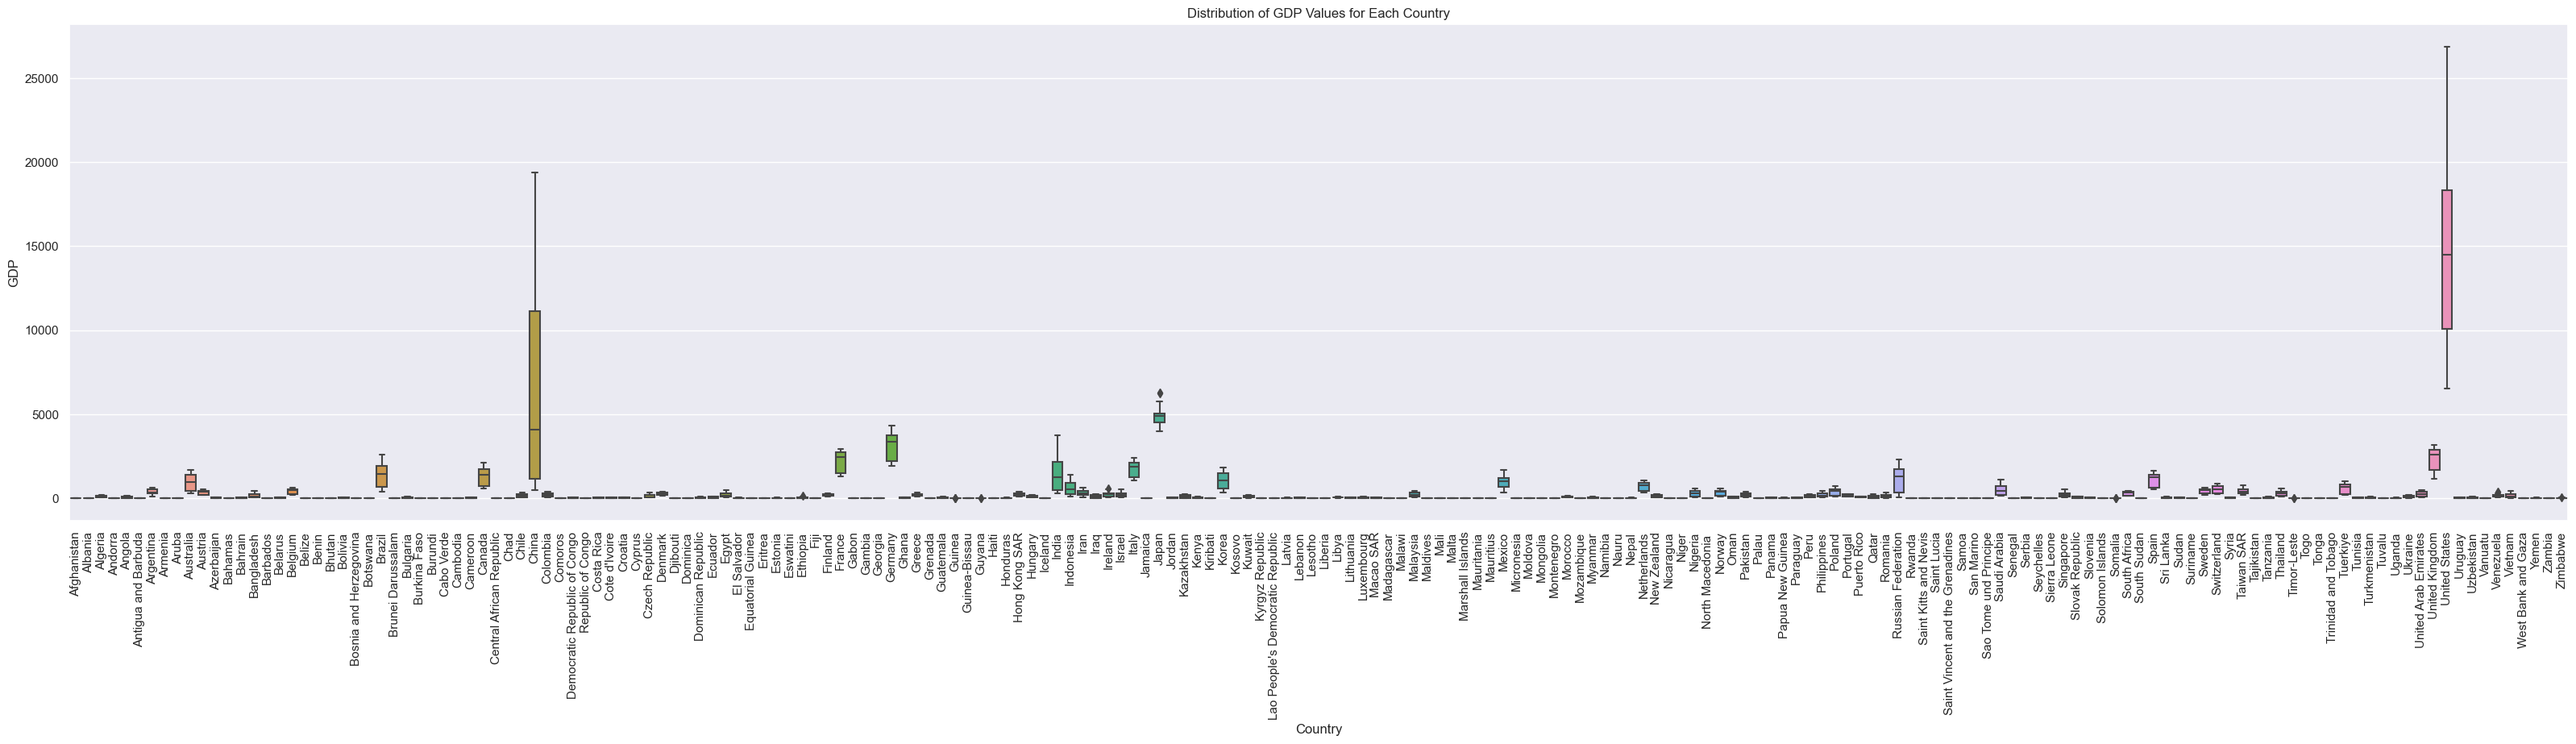

In [35]:
import seaborn as sns

plt.figure(figsize=(40, 8))
sns.boxplot(x='Country', y='GDP', data=gdp)
plt.title('Distribution of GDP Values for Each Country')
plt.xticks(rotation=90) # This makes the country names vertical so they don't overlap
plt.show()

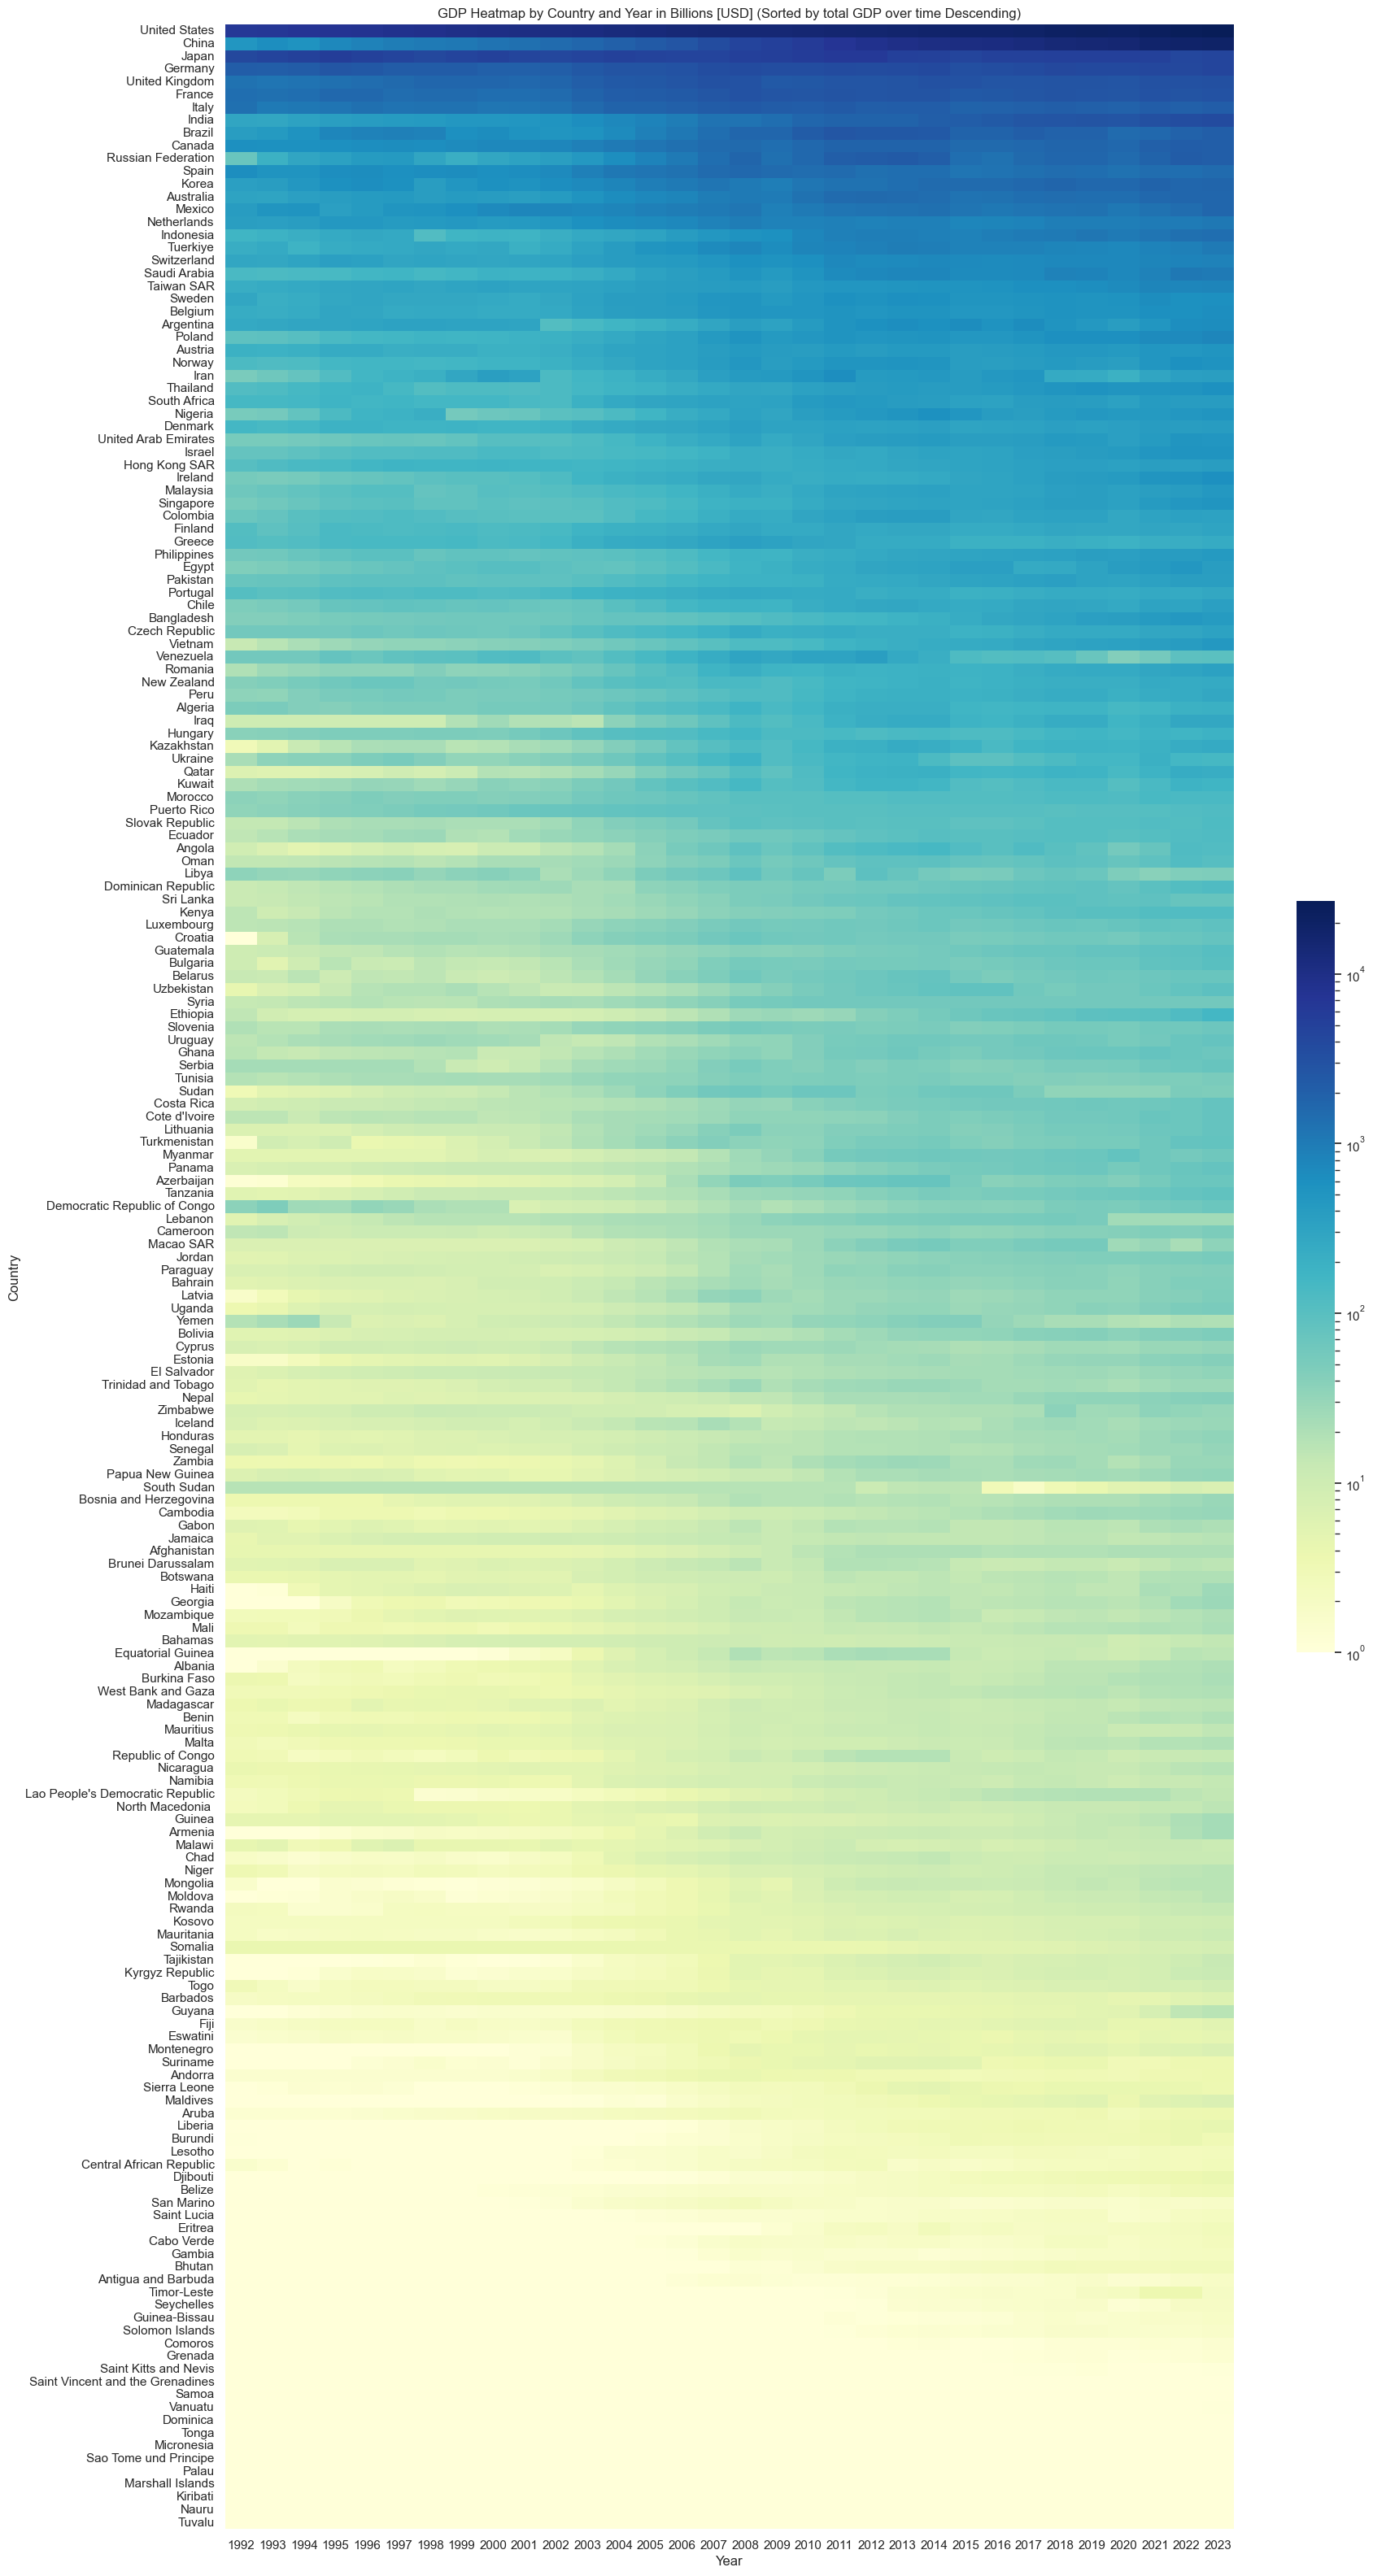

In [36]:
import matplotlib.colors as clrs


def heatmap_normal_scaling_ordered_alphabetical():
    pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

    plt.figure(figsize=(20, 40))  # Adjust the figure size as needed
    sns.heatmap(pivot_data, cmap='YlGnBu', cbar_kws={"shrink": 0.3})
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.title('GDP Heatmap by Country and Year')

    plt.show()

def heatmap_log_scaling_ordered_alphabetical():
    pivot_data = gdp.pivot(index='Country', columns='year', values='GDP').fillna(0)

    # Create a heatmap with log scaling for the legend
    plt.figure(figsize=(20, 40))
    sns.heatmap(pivot_data, cmap='YlGnBu', norm=clrs.LogNorm(vmin=1, vmax=pivot_data.values.max()), cbar_kws={"shrink": 0.3})
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.title('GDP Heatmap by Country and Year (Log Scaling)')


def heatmap_log_scaling_ordered_gdp(): 
    pivot_data = gdp.pivot(index='Country', columns='year', values='GDP').fillna(0)

    # Calculate the total GDP for each country and sort by GDP in descending order
    total_gdp = pivot_data.sum(axis=1)
    sorted_countries = total_gdp.sort_values(ascending=False).index

    # Reorder the rows in the pivot_data DataFrame based on the sorted countries
    pivot_data_sorted = pivot_data.loc[sorted_countries]

    # Create a heatmap with log scaling for the legend
    plt.figure(figsize=(20, 40))
    sns.heatmap(pivot_data_sorted, cmap='YlGnBu', norm=clrs.LogNorm(vmin=1, vmax=pivot_data.values.max()), cbar_kws={"shrink": 0.3})
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.title('GDP Heatmap by Country and Year in Billions [USD] (Sorted by total GDP over time Descending)')
    plt.show()


#heatmap_normal_scaling_ordered_alphabetical()
#heatmap_log_scaling_ordered_alphabetical()
heatmap_log_scaling_ordered_gdp()

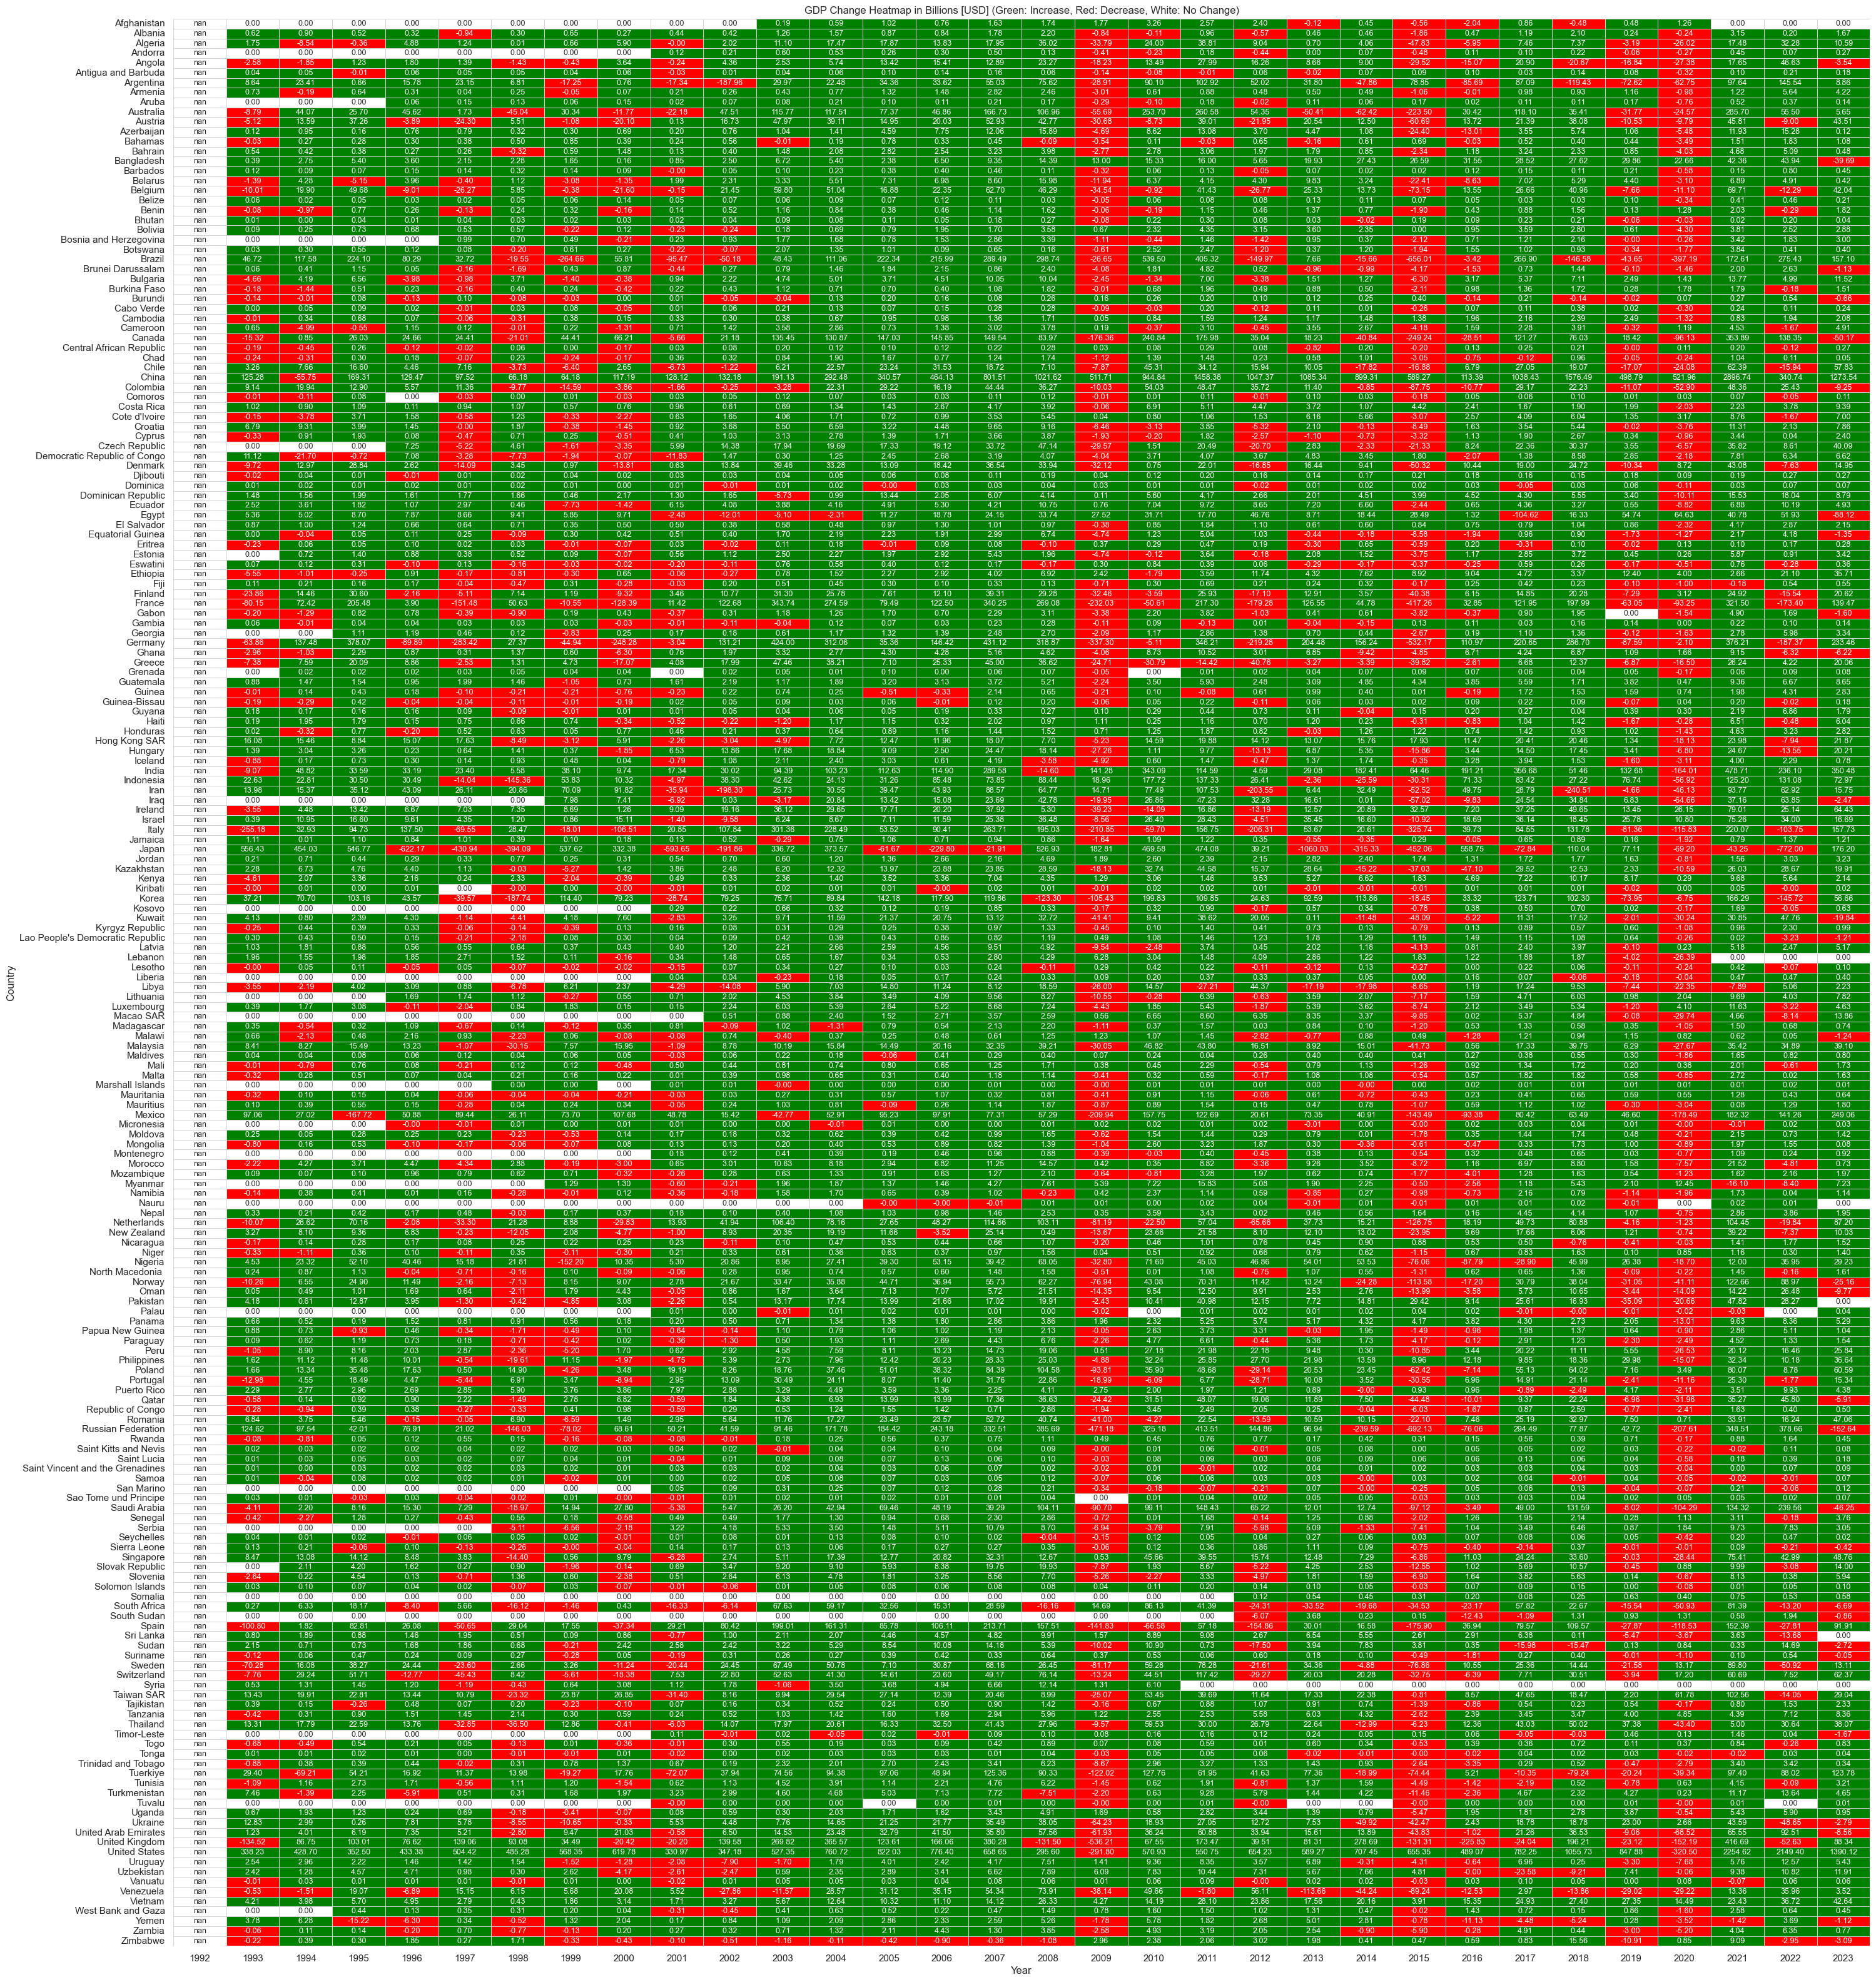

In [37]:

## Create a heatmap of the change in GDP from one year to the next for each country
dfh = gdp
# create a new column for the change in GDP from one year to the next
dfh['gdp_change'] = dfh.groupby('Country')['GDP'].diff()
dfh['gdp_change_category'] = np.where(dfh['gdp_change'] > 0, 'Increase', np.where(dfh['gdp_change'] < 0, 'Decrease', 'No Change'))

# create a mapper to map the gdp_change_category column to numerical values
mapper = {'Increase': 1, 'No Change': 0, 'Decrease': -1}

# Map the gdp_change_category column to numerical values
dfh['gdp_change_category'] = dfh['gdp_change_category'].map(mapper)

# Pivot the DataFrame to have years as columns and countries as index
df_pivot = dfh.pivot(index='Country', columns='year', values='gdp_change_category')

# Create a colormap
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'white', 'green'])


## Calculate the absolute change in gdp from one year to the next as annotation for the heatmap
# Pivot the data to have each country's GDP as a separate column
pivot_data_labels = gdp.pivot(index='Country', columns='year', values='GDP')
# Calculate the change in GDP for each country from one year to the next
gdp_change_label = pivot_data_labels.diff(axis=1)


# Plot the heatmap
plt.figure(figsize=(35, 40))
sns.heatmap(df_pivot, annot=gdp_change_label, annot_kws={"fontsize":9}, cmap=cmap, cbar=False, linewidths=0.5, linecolor='lightgrey', fmt=".2f")
plt.xlabel('Year')
plt.ylabel('Country')
plt.title('GDP Change Heatmap in Billions [USD] (Green: Increase, Red: Decrease, White: No Change)')

plt.show()

In [38]:
%%capture
import bar_chart_race as bcr

# Assuming you have already loaded the data into a DataFrame named 'data'
# Let's say the columns are: 'Country', 'Year', 'GDP'

# Pivot the data to have each country's GDP as a separate column
pivot_data_race = gdp.pivot(index='Country', columns='year', values='GDP')
pivot_data_race.columns = pd.to_datetime(pivot_data_race.columns, format='%Y')

# Transpose the DataFrame to have years as columns and countries as rows
pivot_data_race = pivot_data_race.T


# Create the bar chart race animation
bcr.bar_chart_race(
    df=pivot_data_race,
    filename='highest_gdp_comparison.gif',
    orientation='h',       # Horizontal bars
    sort='desc',           # Sort bars in descending order at each frame
    n_bars=20,             # Number of bars (countries) to include in each frame
    steps_per_period=10,   # Number of steps (frames) per year
    period_length=500,     # Length of each period (milliseconds)
    title='Top 20 Countries with Highest GDPs in Billions (USD) with median',
    bar_label_size=7,      # Font size of bar labels
    tick_label_size=7,     # Font size of tick labels
    period_fmt='%Y',       # Show only the year for periodic steps
    shared_fontdict={'family': 'Helvetica', 'color': '.1'},  # Font settings
    filter_column_colors=True,  # Apply the color from the final frame to all frames
    perpendicular_bar_func='median',  # Set the median as the reference line
)

![SegmentLocal](highest_gdp_comparison.gif "segment")

#### b)
Pick a year with as little missing values as possible. <br>
For this year, create an interactive map with `folium` that tells you the GDP in the country in the given year. <br>
*Hint: Be cautious with country names.*

In [39]:
gdp_05 = gdp[gdp['year']==2005]

In [40]:
gdp_05.shape

(196, 5)

In [42]:
from geopy.geocoders import Nominatim

# Initialize the geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

# Create a world map
world_map= folium.Map(location=[10, -20], zoom_start=2.3)

# Loop over each country and its GDP
for idx, row in gdp_05.iterrows():
    # Get the location of the country
    location = geolocator.geocode(row['Country'])

    # If the location is found
    if location is not None:
        # Add a marker to the map
        folium.Marker(
            location=[location.latitude, location.longitude], 
            popup=f"Country: {row['Country']}, GDP: {row['GDP']}",
        ).add_to(world_map)

# Show the map
world_map


# Problem 3 - Supervised Machine Learning
#### a)
First, try to predict the GDP in a given year and in a given country using the data from the past years. <br>
Report the performance (measured in mean squared error) for different numbers of lags. 

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
def train_model(df, country, model, lags):
    df_country = df[df['Country']==country].drop('Country', axis=1)
    df_country = df_country.sort_values(by='year').drop('year', axis=1)
    for lag in range(1, lags+1):
        df_country[f'GDP_lag_{lag}'] = df_country['GDP'].shift(lag)
    
    df_country = df_country.dropna()
    X_train, X_test, y_train, y_test = train_test_split(df_country.drop('GDP', axis=1),df_country['GDP'], test_size=.3,  shuffle=False)
    model.fit(X_train, y_train)
    mse = model.score(X_test, y_test)
    return mse

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [46]:
linear = LinearRegression()
boost = AdaBoostRegressor(n_estimators=50, random_state=0)
forest = RandomForestRegressor(n_estimators = 50, random_state=0)
models = [linear, boost, forest]
rows = []
df = pd.DataFrame(columns=['Country', 'lag', 'model', 'mse'])
for country in gdp['Country'].unique():
    row = {'Country': country}
    for lags in range (1, 6):
        row['lag'] = lags
        for model in models:
            row['model'] = type(model).__name__
            row['mse'] = train_model(gdp, country, model, lags)
            new_row = pd.DataFrame([row], columns=df.columns)
            df = pd.concat([df, new_row], axis=0, ignore_index=True)

df.head()

Country lag                  model        mse
0  Afghanistan   1       LinearRegression   1.000000
1  Afghanistan   1      AdaBoostRegressor  -0.542881
2  Afghanistan   1  RandomForestRegressor -16.699329
3  Afghanistan   2       LinearRegression   1.000000
4  Afghanistan   2      AdaBoostRegressor  -1.135511

In [47]:
df.sort_values(by=['mse'], inplace=True)
df.tail()

Country lag             model  mse
993        Greece   2  LinearRegression  1.0
2124        Qatar   4  LinearRegression  1.0
996        Greece   3  LinearRegression  1.0
984         Ghana   4  LinearRegression  1.0
0     Afghanistan   1  LinearRegression  1.0

#### b)
Now, see if you can improve the prediction with additional data. <br>
In this task, you are supposed to be creative and use your intuition. What could be important predictors? Think of, for example:
- Country characteristics such as population, unemployment rates etc. <br> *Hint: You can search for official statistics, e.g., from OECD.*
- Major historical events such as wars, natural disasters etc. <br> *Hint: You can make dummy variables if such an event happened for given country and year.*
- Geographical information such as continent.

*Note: It is well possible that you can't find data on very small countries. If you don't find data for some countries, you can drop them.*

In [ ]:
# Insert your code here.

# Problem 4 - Unsupervised Machine Learning 
Use GDP and the information from Problem 3b) to cluster countries. <br>
Which is the optimal number of clusters? <br>
Can you provide an intuition for the clusters you identified?

c:\Users\m3ndel\Documents\Programming\TIDS\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



<Axes: title={'center': 'Average GDP per Cluster per Year'}, xlabel='year'>

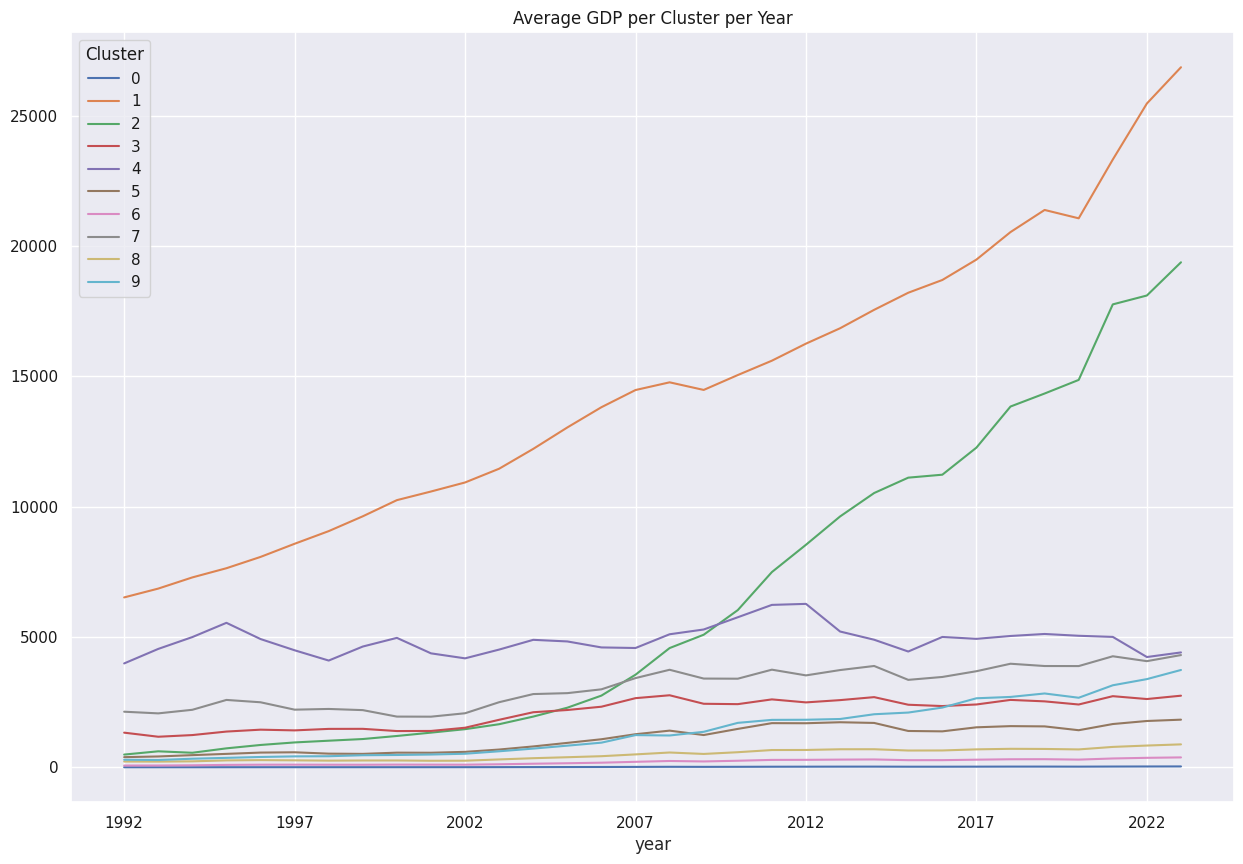

In [79]:
from sklearn.cluster import KMeans

pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

# Perform k-means clustering
k = 10  # Change this value to the desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(pivot_data)

# Add the cluster labels to the DataFrame
pivot_data['Cluster'] = clusters

# get average gdp per cluster per year
pivot_data_1 = pivot_data.groupby('Cluster').mean()

# display the gdp per cluster per year as a line chart
pivot_data_1.T.plot(figsize=(15, 10), title='Average GDP per Cluster per Year')

c:\Users\m3ndel\Documents\Programming\TIDS\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



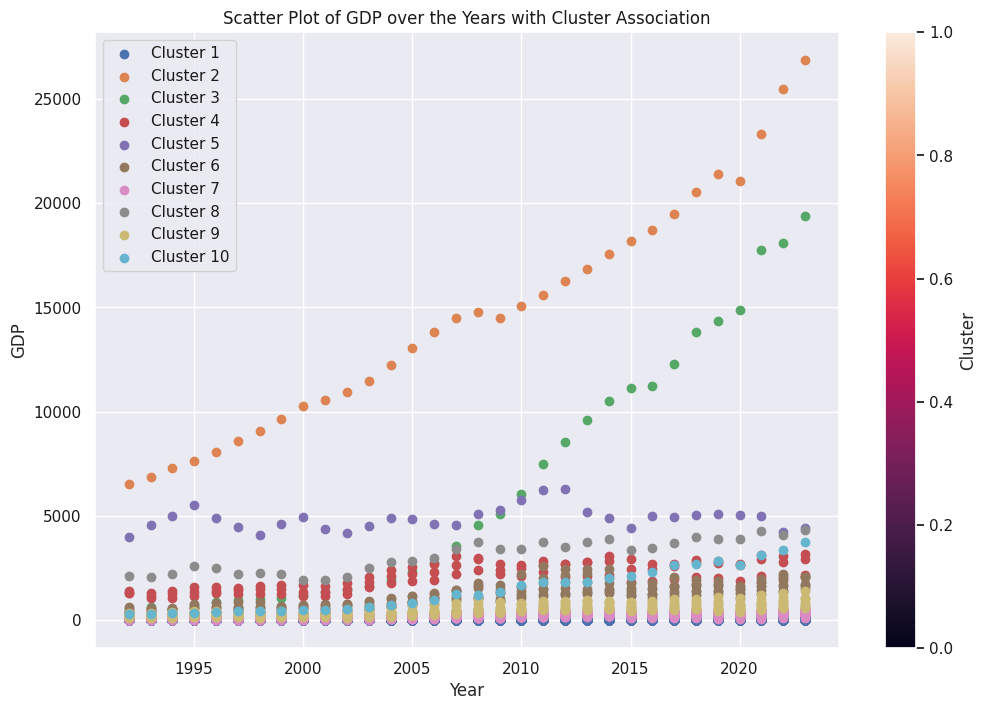

In [80]:
pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

# Perform KMeans clustering
k = 10  # Change this value to the desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(pivot_data)

# Create a list to accumulate data for plot_data DataFrame
plot_data_list = []

for country in pivot_data.index:
    for year in pivot_data.columns:
        gdp_fl = pivot_data.loc[country, year]
        cluster_idx = pivot_data.index.get_loc(country)
        cluster = clusters[cluster_idx]
        plot_data_list.append({'Country': country, 'year': year, 'GDP': gdp_fl, 'Cluster': cluster})

# Create the plot_data DataFrame
plot_data = pd.DataFrame(plot_data_list)

# Create a scatter plot, color-coded by cluster
plt.figure(figsize=(12, 8))
for cluster_id in range(k):
    cluster_data = plot_data[plot_data['Cluster'] == cluster_id]
    plt.scatter(cluster_data['year'], cluster_data['GDP'], label=f'Cluster {cluster_id + 1}')

plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('Scatter Plot of GDP over the Years with Cluster Association')
plt.legend()
plt.colorbar(label='Cluster')
plt.show()

c:\Users\m3ndel\Documents\Programming\TIDS\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



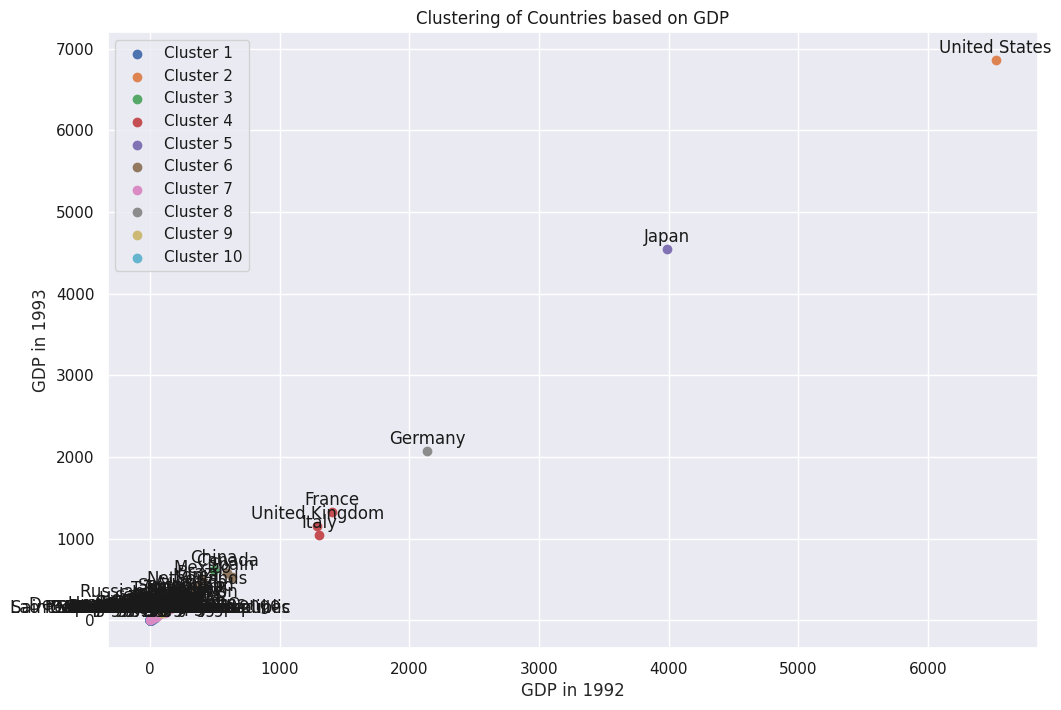

In [82]:
# Create a pivot table to reshape the DataFrame (Country as index, year as columns, and GDP as values)
pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

# Perform KMeans clustering
k = 10  # Change this value to the desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(pivot_data)

# Add the cluster labels to the DataFrame
pivot_data['Cluster'] = clusters

# Create a scatter plot, color-coded by cluster
plt.figure(figsize=(12, 8))
for cluster_id in range(k):
    cluster_data = pivot_data[pivot_data['Cluster'] == cluster_id]
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {cluster_id + 1}')

    # Add annotations (country names) near the data points
    for _, row in cluster_data.iterrows():
        plt.annotate(row.name, (row.iloc[0], row.iloc[1]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel('GDP in 1992')  # Replace with an appropriate label
plt.ylabel('GDP in 1993')  # Replace with an appropriate label
plt.title('Clustering of Countries based on GDP')
plt.legend()
plt.show()

c:\Users\m3ndel\Documents\Programming\TIDS\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



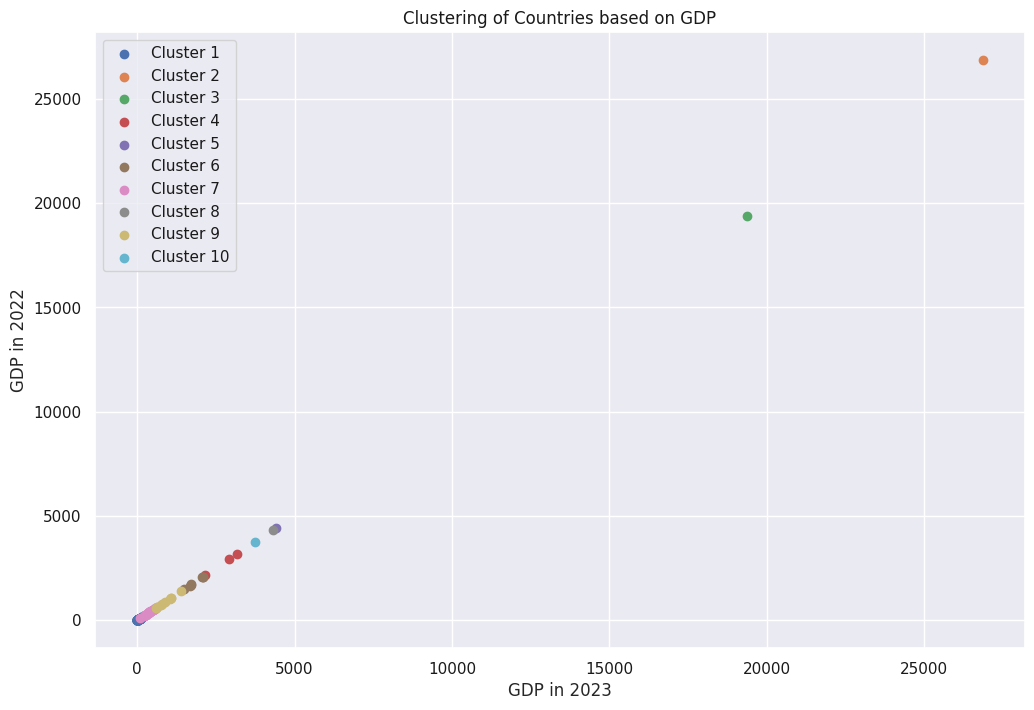

In [83]:
# Create a pivot table to reshape the DataFrame (Country as index, year as columns, and GDP as values)
pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

# Perform KMeans clustering
k = 10  # Change this value to the desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(pivot_data)

# Add the cluster labels to the DataFrame
pivot_data['Cluster'] = clusters

# Create a scatter plot, color-coded by cluster
plt.figure(figsize=(12, 8))
for cluster_id in range(k):
    cluster_data = pivot_data[pivot_data['Cluster'] == cluster_id]
    last_year = pivot_data.columns[-2]  # Use the last year's column, assuming the last column is 'Cluster'
    plt.scatter(cluster_data[last_year], cluster_data.iloc[:, -2], label=f'Cluster {cluster_id + 1}')

    # Add annotations (country names) near the data points
    #for _, row in cluster_data.iterrows():
    #    plt.annotate(row.name, (row[last_year], row.iloc[-2]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel(f'GDP in {last_year}')  # Replace with an appropriate label
plt.ylabel(f'GDP in {last_year - 1}')  # Replace with an appropriate label
plt.title('Clustering of Countries based on GDP')
plt.legend()
plt.show()

In [84]:
import plotly.express as px

# Create a pivot table to reshape the DataFrame (Country as index, year as columns, and GDP as values)
pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

# Perform KMeans clustering
k = 10  # Change this value to the desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(pivot_data)

# Add the cluster labels to the DataFrame
pivot_data['Cluster'] = clusters

# Use plotly express to create an interactive scatter plot
fig = px.scatter(pivot_data, x=pivot_data.columns[-2], y=pivot_data.columns[-3], color='Cluster',
                 hover_name=pivot_data.index)

# Update the axis labels and title
last_year = pivot_data.columns[-2]
second_last_year = pivot_data.columns[-3]
fig.update_layout(
    xaxis_title=f'GDP in {last_year}',
    yaxis_title=f'GDP in {second_last_year}',
    title='Clustering of Countries based on GDP',
    showlegend=True
)

# Show the interactive plot
fig.show()

c:\Users\m3ndel\Documents\Programming\TIDS\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

